# Homework 4. SNN model
*Брылёва Екатерина, группа  МБД191*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

# 1. Реализовать модель импульсной нейронной сети

---



In [3]:
nu = 1 # the threshold
tau = 1 #time constant
tau_s = 1 #time constant
#d_ijax describes the axonal transmission delay

In [4]:
def eta(s):
  return -nu * np.exp(-s / tau) * (1 if s > 0 else 0)
def epsilon(s, d_ijax):
  return (s - d_ijax) / tau_s * np.exp(-(s - d_ijax) / tau_s) * (1 if s - d_ijax > 0 else 0)   
def target_spiking(output, target):
  return output[target] == 1
def convert_out_spikes(output):
  assert np.sum(output) == 1
  return np.argmax(output)     

In [5]:
def plot(ax, xs, ys, color, label, xlabel, ylabel):
  plt.plot(xs, ys, color, label=label)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend(loc='best')

### 1) Реализуйте SRM

### 2) Реализуйте STDP алгоритм обучения без учителя

### 3) Реализуйте обучение с учителем на базе reward'a

In [31]:
class SNN_model:
  def __init__(self, in_neurons_size, hid_neurons1_size, hid_neurons2_size, out_neurons_size, u_spike = 0.3, t_max=1000, min_synapses = 3, max_synapses = 7, max_delay =5):
    self.in_neurons_size = in_neurons_size
    self.hid_neurons1_size = hid_neurons1_size
    self.hid_neurons2_size = hid_neurons2_size
    self.out_neurons_size = out_neurons_size
    self.t_max = t_max
    self.u_spike = u_spike
    self.dts = []
    self.dws = []

    self.u1 = np.zeros((t_max, hid_neurons1_size))
    self.u2 = np.zeros((t_max, hid_neurons2_size))
    self.u3 = np.zeros((t_max, out_neurons_size))

    self.syn_cnt1 = np.random.randint(low=1, high=6, size=(in_neurons_size, hid_neurons1_size))
    self.syn_cnt2 = np.random.randint(low=1, high=6, size=(hid_neurons1_size, hid_neurons2_size))
    self.syn_cnt3 = np.random.randint(low=1, high=6, size=(hid_neurons2_size, out_neurons_size)) 

    self.w1 = 0.00001 + np.random.random((in_neurons_size, hid_neurons1_size))
    self.w2 = 0.00001 + np.random.random((hid_neurons1_size, hid_neurons2_size))
    self.w3 = 0.00001 + np.random.random((hid_neurons2_size, out_neurons_size))

    self.d1 = np.random.randint(low=1, high=8, size=(in_neurons_size, hid_neurons1_size))
    self.d2 = np.random.randint(low=1, high=8, size=(hid_neurons1_size, hid_neurons2_size))
    self.d3 = np.random.randint(low=1, high=8, size=(hid_neurons2_size, out_neurons_size))

    self.prev_t0 = np.zeros(in_neurons_size)
    self.prev_t1 = np.zeros(hid_neurons1_size)
    self.prev_t2 = np.zeros(hid_neurons2_size)
    self.prev_t3 = np.zeros(out_neurons_size)

    self.spikes0 = np.zeros((t_max, in_neurons_size))
    self.spikes1 = np.zeros((t_max, hid_neurons1_size))
    self.spikes2 = np.zeros((t_max, hid_neurons2_size))
    self.spikes3 = np.zeros((t_max, out_neurons_size))

    self.reward = np.ones(t_max)

  #1) реализация SRM
  def SRM(self, in_layer, t):
    for i in range(in_neurons_size):
      if in_layer[i] == 1:
        self.prev_t0[i] = t
        self.spikes0[t, i] = 1

    for i in range(hid_neurons1_size):
      self.u1[t, i] = eta(t - self.prev_t1[i])
      for j in range(in_neurons_size):
        self.u1[t, i] += self.w1[j, i] * epsilon(t - self.prev_t0[j] - self.d1[j, i], self.d1[j, i])
      if self.u1[t, i] > u_spike:
        self.prev_t1[i] = t
        self.spikes1[t, i] = 1

    for i in range(hid_neurons2_size):
      self.u2[t, i] = eta(t - self.prev_t2[i])
      for j in range(hid_neurons1_size):
        self.u2[t, i] += self.w2[j, i] * epsilon(t - self.prev_t1[j] - self.d2[j, i], self.d2[j, i])
      if self.u2[t, i] > u_spike:
        self.prev_t2[i] = t
        self.spikes2[t, i] = 1

    for i in range(out_neurons_size):
      self.u3[i] = eta(t - self.prev_t3[i])
      for j in range(hid_neurons2_size):
        self.u3[t, i] += self.w3[j, i] * epsilon(t - self.prev_t2[j] - self.d3[j, i], self.d3[j, i])
      if self.u3[t, i] > u_spike:
        self.prev_t3[i] = t
        self.spikes3[t, i] = 1

  #2) реализация STDP
  def STDP(self, w_min, w_max, taup, taun, nup, nun, tick, is_visualize = False):
    def STDP_func(in_neurons_size, out_neurons_size, prev_t, prev_tplus1, w):
      for i in range(in_neurons_size):
        for j in range(out_neurons_size):
          d_t = prev_tplus1[j] - prev_t[i]
          if d_t >= 0:
            dw = (w_max - w[i, j]) * nup * np.exp(-d_t/taup)
          else:
            dw = -(w[i, j] - w_min) * nun * np.exp(d_t/taun)

          w[i,j] += dw * self.reward[tick]    
          if is_visualize:
            self.dts.append(d_t)
            self.dws.append(dw)

    STDP_func(self.in_neurons_size, self.hid_neurons1_size, self.prev_t0, self.prev_t1, self.w1)
    STDP_func(self.hid_neurons1_size, self.hid_neurons2_size, self.prev_t1, self.prev_t2, self.w2)
    STDP_func(self.hid_neurons2_size, self.out_neurons_size, self.prev_t2, self.prev_t3, self.w3) 
    


  # 3)Реализация обучения с учителем на базе reward'a                
  def compute_reward(self, tick, target, base_reward = 1.2, steps_to_one = 10):
    out_spikes = self.spikes3[tick]
    if target_spiking(out_spikes, target):
      self.reward[tick] = base_reward
      return
    if tick > 0 and self.reward[tick - 1] > 1.0:
      self.reward[tick] = self.reward[tick - 1] - (base_reward - 1.0) / steps_to_one

  def get_pred_label(self, t):
    out_spikes = self.spikes3[tick]
    if np.sum(out_spikes) == 1:
        return convert_out_spikes(out_spikes)
    return -1

  def reset_reward(self, tick):
      self.reward[tick] = 1.0     

  # Визуализация симуляций  для задания 1

  def visualize_sim_patterns(self):
    time = np.arange(self.t_max)
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize = (25,20))
      
    # Input layer
    ax1.plot(time, np.sum(self.spikes0, axis = 1), 'b')
    ax1.set_xlabel('Время (с)')
    ax1.set_ylabel('Среднее число активных нейронов')
    ax1.set_title('Сенсорный слой')
    ax2.plot(time, self.spikes0[:, np.argmax(np.sum(self.spikes0, axis = 0))], 'b')
    ax2.set_xlabel('Время (с)')
    ax2.set_ylabel('Спайки самого активного нейрона')
    ax2.set_title('Сенсорный слой')
      
    # First hidden layer
    ax3.plot(time, np.sum(self.spikes1, axis = 1), 'r')
    ax3.set_xlabel('Время (с)')
    ax3.set_ylabel('Среднее число активных нейронов')
    ax3.set_title('Первый скрытый слой')
    ax4.plot(time, self.spikes1[:, np.argmax(np.sum(self.spikes1, axis = 0))], 'r')
    ax4.set_xlabel('Время (с)')
    ax4.set_ylabel('Спайки самого активного нейрона')
    ax4.set_title('Первый скрытый слой')
      
    # Second hidden layer
    ax5.plot(time, np.sum(self.spikes2, axis = 1), 'pink')
    ax5.set_xlabel('Время (с)')
    ax5.set_ylabel('Среднее число активных нейронов')
    ax5.set_title('Второй скрытый слой')
    ax6.plot(time, self.spikes2[:, np.argmax(np.sum(self.spikes2, axis = 0))], 'pink')
    ax6.set_xlabel('Время (с)')
    ax6.set_ylabel('Спайки самого активного нейрона')
    ax6.set_title('Второй скрытый слой')
      
    # Output layer
    ax7.plot(time, np.sum(self.spikes3, axis = 1), 'g')
    ax7.set_xlabel('Время (с)')
    ax7.set_ylabel('Среднее число активных нейронов')
    ax7.set_title('Выходной слой')
    ax8.plot(time, self.spikes3[:, np.argmax(np.sum(self.spikes3, axis = 0))], 'g')
    ax8.set_xlabel('Время (с)')
    ax8.set_ylabel('Спайки самого активного нейрона')
    ax8.set_title('Выходной слой') 
      
    plt.show()
    plt.close()

  # Визуализация симуляций  для задания 2

  def visualize_learn_STDP(self): 
    dt = np.array(self.dts)
    dw = np.array(self.dws)
    fig, ax = plt.subplots()
    ax.scatter(dt, dw, s=8, c="blue")
    ax.set_xlim(-50, 50)
    ax.set_ylim(-0.005, 0.005)
    ax.grid()

  # Визуализация симуляций  для задания 3  

  def visualize_reward(self):
    tim = np.arange(self.t_max)
    plt.plot(tim, self.reward, 'r')
    plt.ylim(0.0, 1.3)
    plt.xlim(0, 100)
    plt.show()   

# 2. Анализ


---
Построить графики для каждой симуляции и сделать выводы:


1) Проверка реализации сети. Создайте модель со следующей топологией: сенсорный слой из 5 нейронов, два скрытых слоя по 10 и 20 нейронов и выходной слой из двух нейронов. Значения задержки из [1,5] и веса тоже случайны из (0,1]. Сгенерируйте три случайных паттерна возбуждения, постройте графк среднего числа активных нейронов в каждом слое в зависимости от времени для каждого паттерна и спайт трейна для одного, самого активного нейрона.

pattern 1

In [32]:
lam = 25
in_neurons_size = 5
out_neurons_size = 2
hid_neurons1_size = 10
hid_neurons2_size = 20
min_synapses = 3
max_synapses = 7
max_delay = 5
u_spike = 0.3
epoch_cnt = 5
T = 100
t_max = epoch_cnt * T

def spikes_for_simulation(T, in_neurons_size, lam):
  input_pattern = np.zeros((T, in_neurons_size))
  for i in range(in_neurons_size):
    j = -1
    while j < T:
      j += np.random.poisson(lam, 1)
      if j >= T:
        break
      input_pattern[j, i] = 1
  return input_pattern

input_pattern1 = spikes_for_simulation(T, in_neurons_size, lam)  

model_snn1 = SNN_model(in_neurons_size, hid_neurons1_size, hid_neurons2_size, out_neurons_size, u_spike, t_max, min_synapses, max_synapses, max_delay)
for epoch in range(epoch_cnt):
  for tick in range(T):
    model_snn1.SRM(input_pattern1[tick], epoch * T + tick)


pattern 2 

  

In [33]:
input_pattern2 = spikes_for_simulation(T, in_neurons_size, lam)  

model_snn2 = SNN_model(in_neurons_size, hid_neurons1_size, hid_neurons2_size, out_neurons_size, u_spike, t_max, min_synapses, max_synapses, max_delay)
for epoch in range(epoch_cnt):
  for tick in range(T):
    model_snn2.SRM(input_pattern1[tick], epoch * T + tick)


pattern 3

In [34]:
input_pattern3 = spikes_for_simulation(T, in_neurons_size, lam)  

model_snn3 = SNN_model(in_neurons_size, hid_neurons1_size, hid_neurons2_size, out_neurons_size, u_spike, t_max, min_synapses, max_synapses, max_delay)
for epoch in range(epoch_cnt):
  for tick in range(T):
    model_snn3.SRM(input_pattern1[tick], epoch * T + tick)


Графики pattern 1

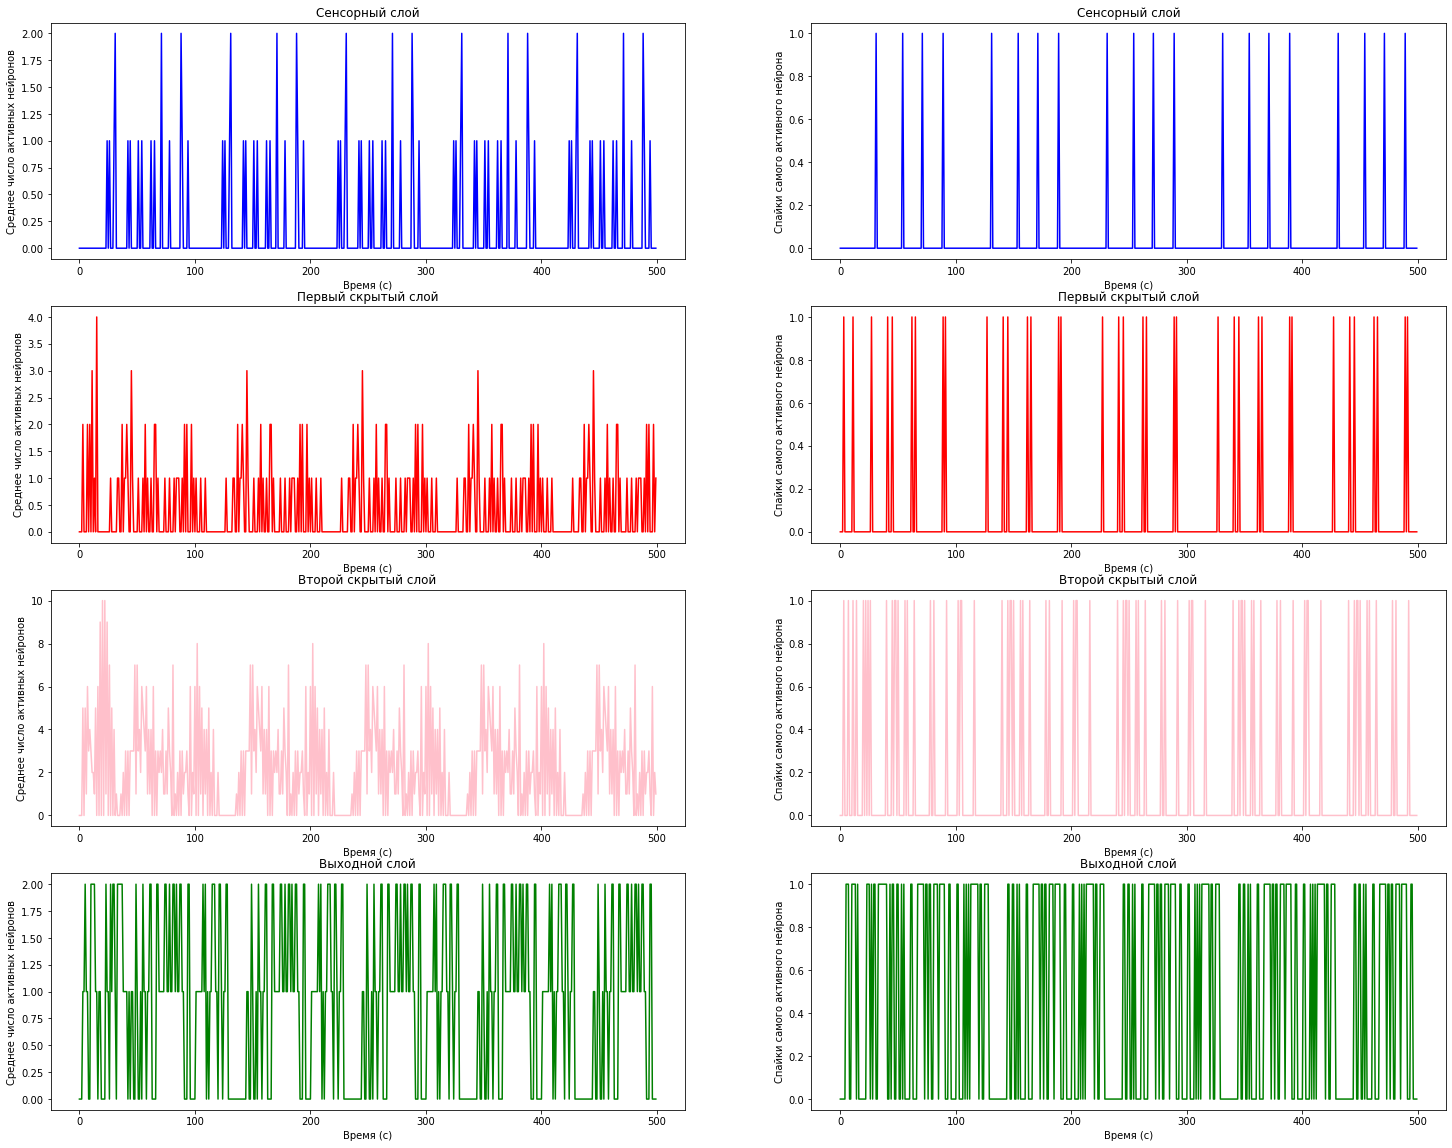

In [35]:
model_snn1.visualize_sim_patterns()

Графики pattern 2

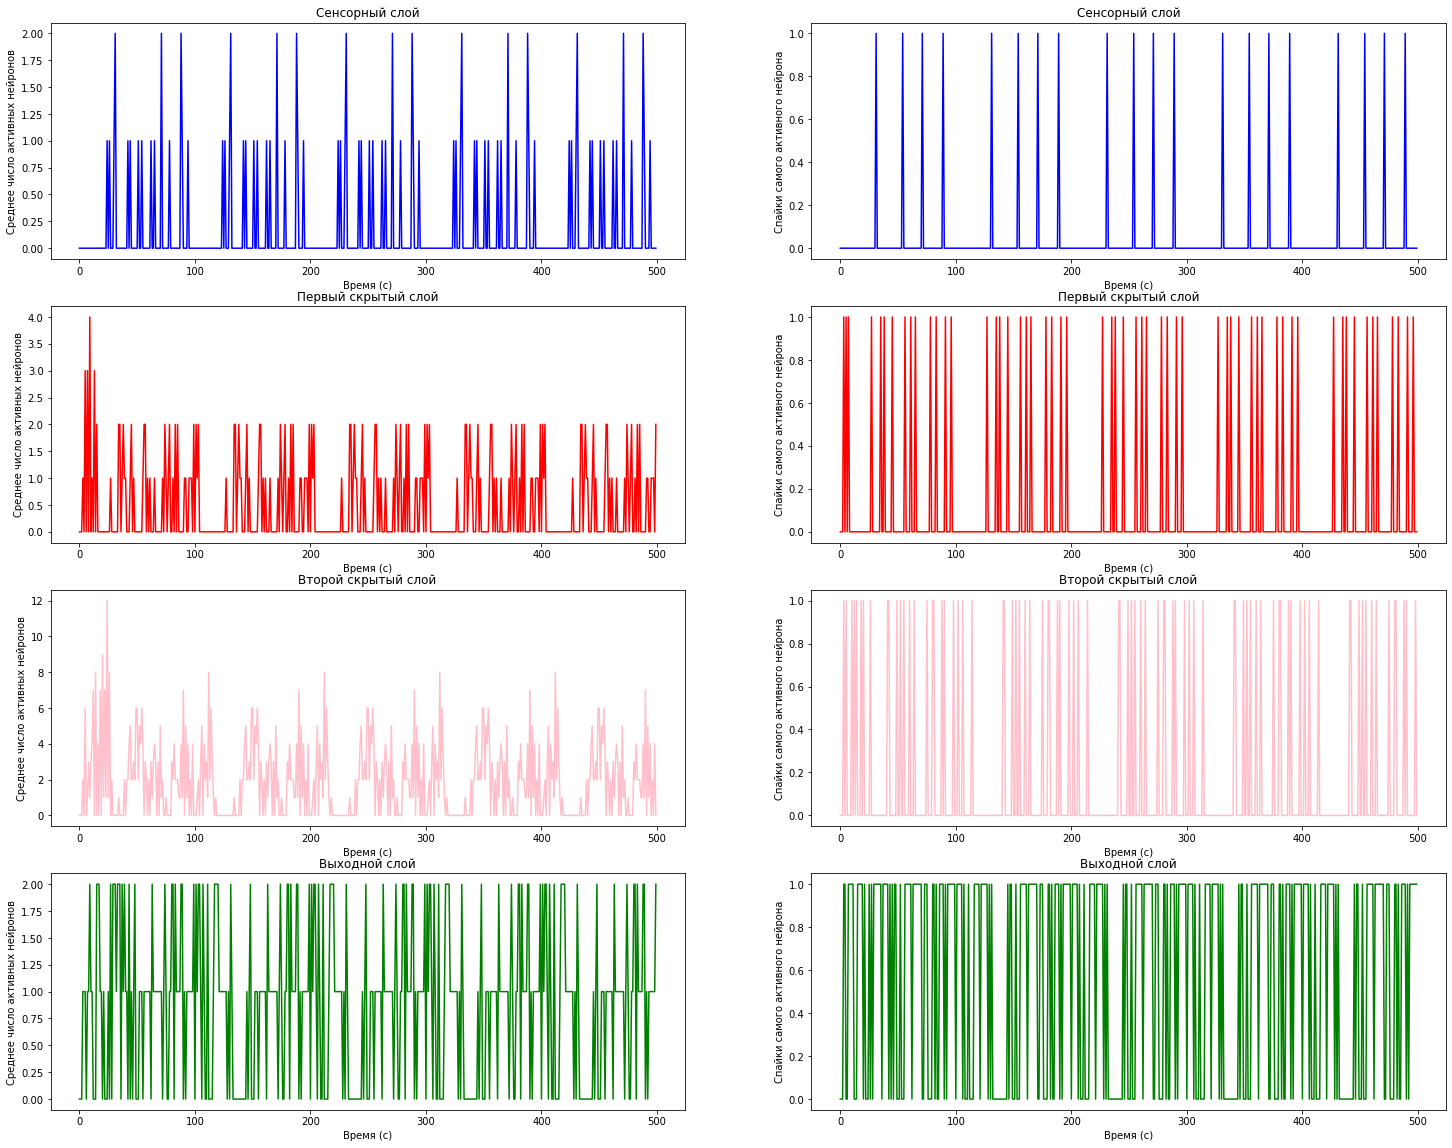

In [36]:
model_snn2.visualize_sim_patterns()

Графики pattern 3

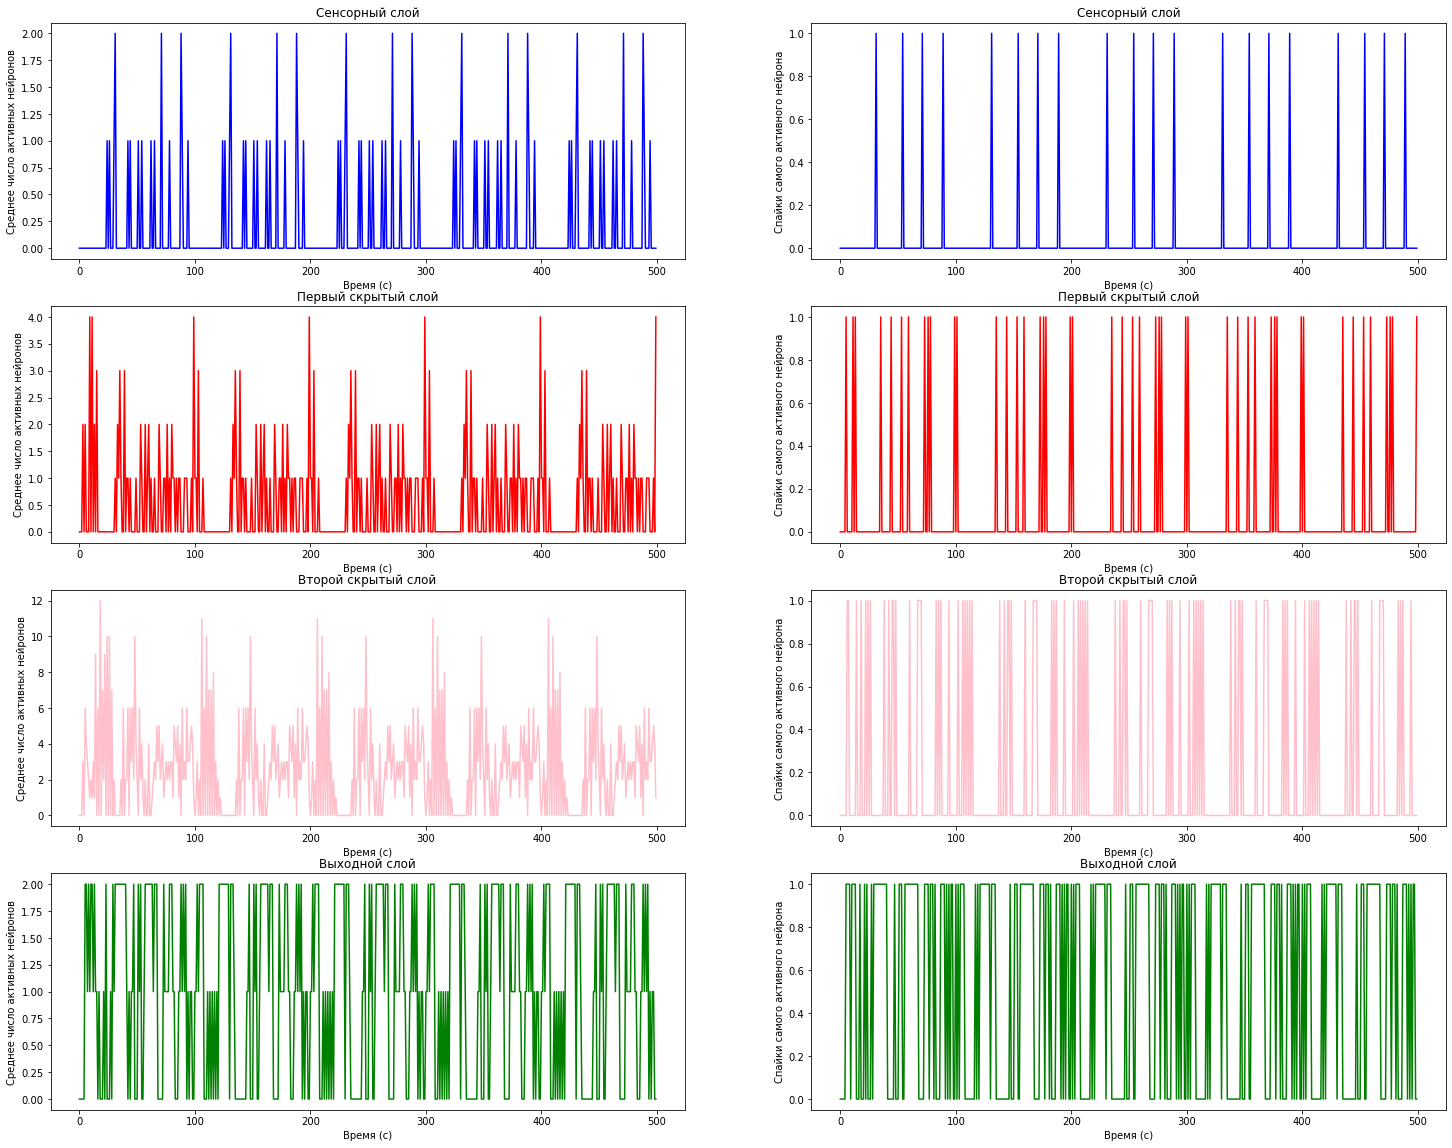

In [37]:
model_snn3.visualize_sim_patterns()

2) Обучите вашу сеть без учителя на датасете MNIST. Для этого вам нужна будет сеть с 256 сенсорными нейронами, два слоя скрытых нейронов по 128 и 64 нейрона, и 10 в выходном слое. Стимул задается как матрица со значениями пикселя из соответствующей позиции. Различаются ли паттерны активации в зависимости от класса? Нарисуйте несколько из них.

Визуализируем модель STDP

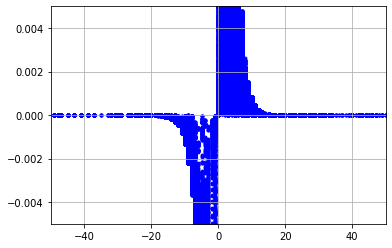

In [10]:
lam = 25
epoch_cnt= 5
T = 100
t_max = epoch_cnt * T

input_pattern4 = spikes_for_simulation(T, in_neurons_size, lam)

model_stdp = SNN_model(in_neurons_size, hid_neurons1_size, hid_neurons2_size, out_neurons_size, u_spike, t_max, min_synapses, max_synapses, max_delay)
for epoch in range(epoch_cnt):
  for tick in range(T):
    model_stdp.SRM(input_pattern4[tick], epoch * T + tick)
    model_stdp.STDP(0, 1, 1.7, 2.0, 0.3, 0.2, tick, is_visualize=True)

model_stdp.visualize_learn_STDP()

*Обучение сети*

In [11]:
# загружаем датасет
from google.colab import files
uploaded = files.upload()


Saving mnist_train.psv to mnist_train (1).psv


In [12]:
from google.colab import files
uploaded = files.upload()

Saving mnist_test.psv to mnist_test (1).psv


In [17]:
def train_mnist():
    train_mnist = pd.read_csv("mnist_train (1).psv", sep="|", header=None)
    train_df = train_mnist.to_numpy()
    return train_df[:10, 1:], train_df[:10, 0]
def test_mnist():
    test_mnist = pd.read_csv("mnist_test (1).psv", sep="|", header=None)
    test_df = test_mnist.to_numpy()
    return test_df[:5, 1:], test_df[:5, 0]
def MNIST_spikes(data, T):
    assert len(data) == 256

    result = np.zeros((T, 256))
    for i in range(256):
        pixels = data[i]
        lam = 1 + T * (1 - (pixels + 1) / 2.0)

        j = -1
        while j < T:
            j += np.random.poisson(lam, 1)
            if j >= T:
                break
            result[j, i] = 1

    return result

In [18]:
train_x, train_y = train_mnist()
test_x, test_y = test_mnist()

In [19]:
len(train_x)

10

In [20]:
len(test_x)

5

Обновляем параметры

In [21]:
in_neurons_size = 256
out_neurons_size = 10
hid_neurons1_size = 128
hid_neurons2_size = 64
min_synapses = 3
max_synapses = 7
max_delay = 5
u_spike = 0.3
epoch_cnt = len(train_y)
T = 100
t_max = epoch_cnt * T

In [22]:
model_mnist = SNN_model(in_neurons_size, hid_neurons1_size, hid_neurons2_size, out_neurons_size, u_spike, t_max, min_synapses, max_synapses, max_delay)
for epoch in range(epoch_cnt):
  input_pattern = MNIST_spikes(train_x[epoch], T)
  target = int(train_y[epoch])
  for tick in tqdm(range(T)):
    cur_time = epoch * T + tick
    model_mnist.SRM(input_pattern[tick], cur_time)
    model_mnist.STDP(0, 1, 1.7, 2.0, 0.3, 0.2, tick, is_visualize=True)



100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


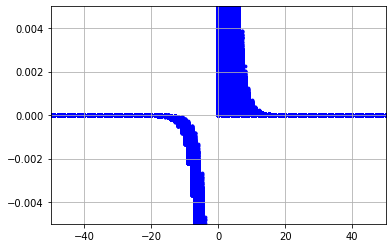

In [23]:
model_mnist.visualize_learn_STDP()

3) Обучите вашу сеть с помощью алгоритма обучения с учителем и посчитайте точность для полученной модели. Создайте несколько топологий сети, варьируя параметры числа нейронов в скрытых слоях. Количество синапсов на связь берется из равномерного распределения с параметрами [3,7]. Постройте график зависимости точности от параметров топологии(число нейронов в каждом слое).

In [25]:
model_rew = SNN_model(in_neurons_size, hid_neurons1_size, hid_neurons2_size, out_neurons_size, u_spike, t_max, min_synapses, max_synapses, max_delay)
for epoch in range(epoch_cnt):
  input_pattern = MNIST_spikes(train_x[epoch], T)
  target = int(train_y[epoch])
  for tick in tqdm(range(T)):
    cur_time = epoch * T + tick
    model_rew.SRM(input_pattern[tick], cur_time)
    model_rew.compute_reward(cur_time, target, 1.2, 10)
    model_rew.STDP(0, 1, 1.7, 2.0, 0.3, 0.2, tick, is_visualize = True)
  model_rew.reset_reward(epoch * (T + 1) - 1)


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]

100%|██████████| 100/100 [00:40<00:00,  2.45it/s]

100%|██████████| 100/100 [00:41<00:00,  2.44it/s]

100%|██████████| 100/100 [00:41<00:00,  2.44it/s]

100%|██████████| 100/100 [00:43<00:00,  2.29it/s]

100%|██████████| 100/100 [00:41<00:00,  2.42it/s]

100%|██████████| 100/100 [00:40<00:00,  2.45it/s]

100%|██████████| 100/100 [00:40<00:00,  2.44it/s]

100%|██████████| 100/100 [00:41<00:00,  2.43it/s]

100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Точность для полученной модели

In [27]:
sum = 0
for i in range(len(test_y)):
    input_pattern = MNIST_spikes(test_x[i], T)
    target = int(test_y[i])

    for tick in range(T):
        model_rew.SRM(input_pattern[tick], tick)
        if target_spiking(model_rew.spikes3[tick], target):
            sum += 1
accuracy = sum / (t_max)
print(accuracy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.


0.186


Сеть обучается очень долго, оперативной памяти не хватило даже если брать выборку - 30. (Так же слетал Colab при 40, 50, 70, 100). Этим объясняется маленькая точность модели.

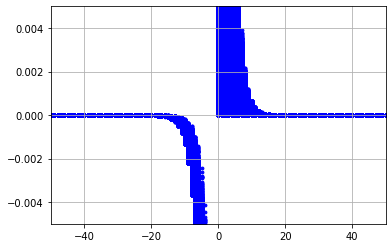

In [30]:
model_rew.visualize_learn_STDP()

# 3. Результат

---
Ссылка на репозиторий с кодом модели, симуляций и построения графиков. 
